# Models

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/lukeconibear/intro_ml/blob/main/docs/03_models.ipynb)

In [28]:
# if you're using colab, then install the required modules
import sys

IN_COLAB = "google.colab" in sys.modules
if IN_COLAB:
    pass

## Hyperparameter tuning

Choosing the best model

[KerasTuner](https://keras.io/guides/keras_tuner/getting_started/)

### Other options

- [TensorFlow Model Optimisation Toolkit](https://www.tensorflow.org/model_optimization)
    - A suite of tools for optimising machine learning models.
- [AutoKeras](https://autokeras.com/)
    - An AutoML system to automate the building of the machine learning model.

In [49]:
import os

import keras_tuner
import tensorflow as tf

Build the model with the `hyperparameters` option.

- The number of units.
- The activation function to use
- Whether to use dropout.
- The optimiser learning rate.

In [50]:
def build_model(hyperparameters):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Flatten())
    model.add(
        tf.keras.layers.Dense(
            units=hyperparameters.Int("units", min_value=32, max_value=512, step=32),
            activation=hyperparameters.Choice("activation", ["relu", "tanh"]),
        )
    )
    if hyperparameters.Boolean("dropout"):
        model.add(tf.keras.layers.Dropout(rate=0.25))
    model.add(tf.keras.layers.Dense(10, activation="softmax"))
    learning_rate = hyperparameters.Float(
        "lr", min_value=1e-4, max_value=1e-2, sampling="log"
    )
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss="categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model

First, prepare a directory to store all the hyperparameters:

In [55]:
import os

hyperparameters_path = f"{os.getcwd()}/../models/hyperparameters"
if not os.path.exists(hyperparameters_path):
    os.makedirs(hyperparameters_path)

Now, initialise the tuner:

In [56]:
tuner = keras_tuner.RandomSearch(
    hypermodel=build_model,  # the model building function
    objective="val_accuracy",  # the objective to optimise
    max_trials=3,  # the number of trials for the search
    executions_per_trial=2,  # the number of models to build and fit per trial
    overwrite=True,  # whether to overwrite previous results
    directory=hyperparameters_path,  # the path for the hyperparameter results
    project_name="hp_example",
)

View the search space:

In [57]:
tuner.search_space_summary()

Search space summary
Default search space size: 4
units (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}
activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh'], 'ordered': False}
dropout (Boolean)
{'default': False, 'conditions': []}
lr (Float)
{'default': 0.0001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.01, 'step': None, 'sampling': 'log'}


Load in the MNIST dataset for this example:

In [59]:
import numpy as np

(x, y), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

x_train = x[:-10000]
x_val = x[-10000:]
y_train = y[:-10000]
y_val = y[-10000:]

x_train = np.expand_dims(x_train, -1).astype("float32") / 255.0
x_val = np.expand_dims(x_val, -1).astype("float32") / 255.0
x_test = np.expand_dims(x_test, -1).astype("float32") / 255.0

num_classes = 10
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_val = tf.keras.utils.to_categorical(y_val, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

Start the search:

In [66]:
tuner.search(x_train, y_train, epochs=2, validation_data=(x_val, y_val), verbose=False)

INFO:tensorflow:Oracle triggered exit


INFO:tensorflow:Oracle triggered exit


View the results.

You can also visualise them using [TensorBoard](https://keras.io/guides/keras_tuner/visualize_tuning/).results

In [65]:
tuner.results_summary()

Results summary
Results in /home/earlacoa/repos/intro_ml/docs/../models/hyperparameters/hp_example
Showing 10 best trials
Objective(name='val_accuracy', direction='max')
Trial summary
Hyperparameters:
units: 224
activation: relu
dropout: True
lr: 0.0008240205445395648
Score: 0.970300018787384
Trial summary
Hyperparameters:
units: 256
activation: tanh
dropout: False
lr: 0.0005641559959354345
Score: 0.9596999883651733
Trial summary
Hyperparameters:
units: 128
activation: tanh
dropout: False
lr: 0.007116165616460776
Score: 0.9544999897480011


Select the best model:

In [62]:
best_model = tuner.get_best_models()[0]

Show the best model's summary.

Note, the `Sequential` model will need to be built first with a input shape.

In [64]:
best_model.build(input_shape=(None, 28, 28))
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 224)               175840    
                                                                 
 dropout (Dropout)           (None, 224)               0         
                                                                 
 dense_1 (Dense)             (None, 10)                2250      
                                                                 
Total params: 178,090
Trainable params: 178,090
Non-trainable params: 0
_________________________________________________________________


## ...

...

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

2022-03-14 16:25:28.299470: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-03-14 16:25:28.299487: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
if tf.config.list_physical_devices("GPU"):
    print(
        f"Yes, there are {len(tf.config.list_physical_devices('GPU'))} GPUs available."
    )
else:
    print("No, GPUs are not available.")

No, GPUs are not available.


2022-03-14 16:25:29.209000: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-03-14 16:25:29.209027: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-03-14 16:25:29.209044: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (UOL-LAP-5G6CZH3): /proc/driver/nvidia/version does not exist


[Keras Applications](https://keras.io/api/applications/)

- DenseNet
- VGG
- EfficientNet
- MobileNet
- Inception
- ResNet

In [15]:
tf.keras.applications.inception_v3.InceptionV3?

Signature:
tf.keras.applications.inception_v3.InceptionV3(
    include_top=True,
    weights='imagenet',
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=1000,
    classifier_activation='softmax',
)
Docstring:
Instantiates the Inception v3 architecture.

Reference:
- [Rethinking the Inception Architecture for Computer Vision](
    http://arxiv.org/abs/1512.00567) (CVPR 2016)

This function returns a Keras image classification model,
optionally loaded with weights pre-trained on ImageNet.

For image classification use cases, see
[this page for detailed examples](
  https://keras.io/api/applications/#usage-examples-for-image-classification-models).

For transfer learning use cases, make sure to read the
[guide to transfer learning & fine-tuning](
  https://keras.io/guides/transfer_learning/).

Note: each Keras Application expects a specific kind of input preprocessing.
For `InceptionV3`, call `tf.keras.applications.inception_v3.preprocess_input`
on your inputs b

https://keras.io/examples/vision/image_classification_efficientnet_fine_tuning/

In [4]:
conv_base = tf.keras.applications.vgg16.VGG16(
    weights="imagenet", include_top=False, input_shape=(180, 180, 3)
)

2022-03-14 16:25:29.237337: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


58900480/58889256 [==============================] - 5s 0us/step


In [5]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 180, 180, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 180, 180, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 90, 90, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 90, 90, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 90, 90, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 45, 45, 128)       0     

## Transfer learning

Transfer learning is where a model that has been pre-trained on a problem is transferred to another similar problem. For example, if a model learnt to classify images it can be transferred to other image classification problems.

Commonly, this is done via:

- Instantiate a pre-trained model and load pre-trained weights into it.
- Extract layers and freeze them (i.e., `trainable = False`) to retain their information (e.g., for lower level features).
- Add new trainable layers on top of these frozen layers.
- Train the new layers on your dataset.
- Optional: Unfreeze the frozen layers and train these on the dataset with a very low learning rate (i.e., fine tuning).

This is useful when:

- You have a small dataset.
- You want to take advantage of huge models without the costs of training them.



...

example

### Example: Transfer learning

In [12]:
import tensorflow as tf
import tensorflow_datasets as tfds

Download and split the data:

In [13]:
# tfds.disable_progress_bar()

train_ds, validation_ds, test_ds = tfds.load(
    "cats_vs_dogs",
    # Reserve 10% for validation and 10% for test
    split=["train[:40%]", "train[40%:50%]", "train[50%:60%]"],
    as_supervised=True,  # Include labels
)

print("Number of training samples: %d" % tf.data.experimental.cardinality(train_ds))
print(
    "Number of validation samples: %d" % tf.data.experimental.cardinality(validation_ds)
)
print("Number of test samples: %d" % tf.data.experimental.cardinality(test_ds))

2022-03-21 12:49:11.513562: W tensorflow/core/platform/cloud/google_auth_provider.cc:184] All attempts to get a Google authentication bearer token failed, returning an empty token. Retrieving token from files failed with "NOT_FOUND: Could not locate the credentials file.". Retrieving token from GCE failed with "FAILED_PRECONDITION: Error executing an HTTP request: libcurl code 6 meaning 'Couldn't resolve host name', error details: Could not resolve host: metadata".


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /home/earlacoa/tensorflow_datasets/cats_vs_dogs/4.0.0.incompleteKAOKTY/cats_vs_dogs-train.tfrecord*.…

Dataset cats_vs_dogs downloaded and prepared to /home/earlacoa/tensorflow_datasets/cats_vs_dogs/4.0.0. Subsequent calls will reuse this data.
Number of training samples: 9305
Number of validation samples: 2326
Number of test samples: 2326


View a few of the training samples:

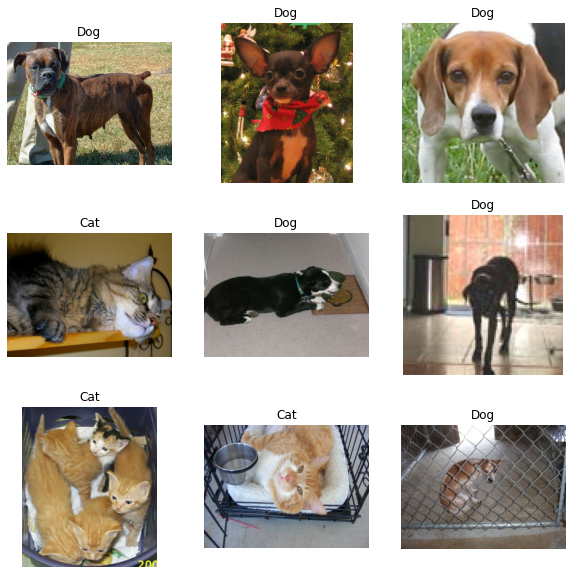

In [15]:
import matplotlib.pyplot as plt

labels = {0: "Cat", 1: "Dog"}

plt.figure(figsize=(10, 10))
for i, (image, label) in enumerate(train_ds.take(9)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image)
    plt.title(labels[int(label)])
    plt.axis("off")

First, preprocess the data.

This is to standardise the image sizes and normalise the pixel values.

In [16]:
size = (150, 150)

train_ds = train_ds.map(lambda x, y: (tf.image.resize(x, size), y))
validation_ds = validation_ds.map(lambda x, y: (tf.image.resize(x, size), y))
test_ds = test_ds.map(lambda x, y: (tf.image.resize(x, size), y))

Now, we can [cache and prefetch](cache_prefetch) the data:

In [17]:
batch_size = 32

train_ds = train_ds.cache().batch(batch_size).prefetch(buffer_size=10)
validation_ds = validation_ds.cache().batch(batch_size).prefetch(buffer_size=10)
test_ds = test_ds.cache().batch(batch_size).prefetch(buffer_size=10)

Apply some [data augmentation](data_augmentation):

In [20]:
data_augmentation = tf.keras.Sequential(
    [
        tf.keras.layers.RandomFlip("horizontal"),
        tf.keras.layers.RandomRotation(0.1),
    ]
)

Now, build the model.

- First, load the pre-trained model as the base.
- Freeze the layers from the base model.
- Add new layers on top.

In [21]:
base_model = tf.keras.applications.Xception(
    weights="imagenet",  # Load weights pre-trained on ImageNet.
    input_shape=(150, 150, 3),
    include_top=False,
)  # Do not include the ImageNet classifier at the top.

# Freeze the base_model
base_model.trainable = False

# Create new model on top
inputs = tf.keras.Input(shape=(150, 150, 3))
x = data_augmentation(inputs)  # Apply random data augmentation

# Pre-trained Xception weights requires that input be scaled
# from (0, 255) to a range of (-1., +1.), the rescaling layer
# outputs: `(inputs * scale) + offset`
scale_layer = tf.keras.layers.Rescaling(scale=1 / 127.5, offset=-1)
x = scale_layer(x)

# The base model contains batchnorm layers. We want to keep them in inference mode
# when we unfreeze the base model for fine-tuning, so we make sure that the
# base_model is running in inference mode here.
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)  # Regularize with dropout
outputs = tf.keras.layers.Dense(1)(x)
model = tf.keras.Model(inputs, outputs)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 150, 150, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 150, 150, 3)       0         
                                                                 
 xception (Functional)       (None, 5, 5, 2048)        20861480  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                             

1% of the parameters are trainable, with 99% from the pre-trained model.

That will save a lot of computation.

Now, train the top layers only:

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.BinaryAccuracy()],
)

In [ ]:
if IN_COLAB:
    epochs = 1  # just 1 for the demonstration, would increase this to say 20 normally
    model.fit(train_ds, epochs=epochs, validation_data=validation_ds)

In [4]:
# # Load a convolutional base with pre-trained weights
# base_model = tf.keras.applications.Xception(
#     weights='imagenet',
#     include_top=False,
#     pooling='avg')

# # Freeze the base model
# base_model.trainable = False

# Use a Sequential model to add a trainable classifier on top
# model = tf.keras.Sequential(
#     [
#         base_model,
#         tf.keras.layers.Dense(1000),
#     ]
# )

# # Compile & train
# model.compile(...)
# model.fit(...)

In [6]:
# model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 2048)              20861480  
                                                                 
 dense (Dense)               (None, 1000)              2049000   
                                                                 
Total params: 22,910,480
Trainable params: 2,049,000
Non-trainable params: 20,861,480
_________________________________________________________________


## [Callbacks](https://keras.io/api/callbacks/)

Callbacks are objects that get called by the model at different points during training, in particular after each batch or epoch.

For example, they could be used to:

- Save a model version at regularly intervals or once attained a metric threshold (i.e., checkpointing).
- Monitor and profile the training progress (i.e., TensorBoard)
- Change the learning rate when training plateaus.
- Fine tuning when the training plateaus.

### [Checkpointing](https://www.tensorflow.org/guide/checkpoint)

For longer or distributed training, it's helpful to save the model (/ model weights) at regular intervals in case it crashes during training (i.e. [model checkpointing](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint)).

In [9]:
callback_model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath="models/model_{epoch}",
    save_freq="epoch",  # save a model version at the end of each epoch
    save_best_only=True,  # only save a model if val_accuracy improved
    monitor="val_accuracy",
)

### Tensorboard and Profiling

[TensorBoard](https://www.tensorflow.org/tensorboard) is a browser-based application that provides live plots of loss and metrics for training and evaluation.

You can add [profiling](https://www.tensorflow.org/guide/profiler) too.

In [10]:
callback_tensorboard_with_profiling = tf.keras.callbacks.TensorBoard(
    log_dir="logs",
    profile_batch=(1, 5),  # profile batches 1 to 5
    update_freq="epoch",
)

2022-03-17 18:23:38.197379: I tensorflow/core/profiler/lib/profiler_session.cc:110] Profiler session initializing.
2022-03-17 18:23:38.197406: I tensorflow/core/profiler/lib/profiler_session.cc:125] Profiler session started.
2022-03-17 18:23:38.197650: I tensorflow/core/profiler/lib/profiler_session.cc:143] Profiler session tear down.


View them with:

In [ ]:
# !tensorboard --logdir=/full_path_to_your_logs

Also, in-line in [Jupyter Notebooks / Google Colab](https://www.tensorflow.org/tensorboard/tensorboard_in_notebooks)

### Metric threshold

Stop training when a monitored metric has stopped improving (i.e., [early stopping](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping)).

In [8]:
callback_accuracy_threshold = tf.keras.callbacks.EarlyStopping(
    monitor="val_accuracy",  # quantity to be monitored
    min_delta=1e-2,  # "no longer improving" means "stopped improving by at least 1e-2"
    patience=2,  # "no longer improving" also means "for at least 2 epochs"
    verbose=1,
)

### Learning rate decay

Reduce learning rate when a metric has stopped improving (i.e., [reduce the learning rate on plateau](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ReduceLROnPlateau)).

In [ ]:
callback_learning_rate_decay = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_accuracy",
    patience=5,
    factor=0.2,  # factor by which the learning rate will be reduced: new_lr = lr * factor
    min_lr=0.001,  # lower bound on the learning rate
)

### Example: Callbacks

In [ ]:
callbacks = [
    callback_model_checkpoint,
    callback_tensorboard_with_profiling,
    callback_accuracy_threshold,
    callback_learning_rate_decay,
]

In [ ]:
# model.fit(dataset, epochs=5, callbacks=callbacks)

## Compiling

Compile any function in TensorFlow by wrapping it in the [`@tf.function`](https://www.tensorflow.org/api_docs/python/tf/function) decorator.

This convert it from eager execution to a static graph.



## Exercises

```{admonition} Exercise 1

...

```

## {ref}`Solutions <models>`

## Key Points

```{important}

- [x] _Tune the models hyperparamaters for the best fit._
- [x] _Use transfer learning to save computation on similar problems._

```

## Further information

### Good practices

- See if there is a model architecture (and parameters) that already addresses the task.
- Consider the tradeoff between model complexity and size.
    - For high accuracy, maybe need a large and complex model.
    - For less precision, smaller models use less disk space, memory, and are faster.
    

### Other options

- ...
 
### Resources

#### General

- [Model Zoo](https://modelzoo.co/)
- [Papers with code - Models](https://paperswithcode.com/methods)
- [HuggingFace - Models](https://huggingface.co/models)

#### TensorFlow

- [TensorFlow Hub](https://tfhub.dev/) for pre-trained models.
- [TensorFlow Model Garden](https://github.com/tensorflow/models/tree/master/official) for model source code.

#### PyTorch

- [PyTorch Hub](https://pytorch.org/docs/stable/hub.html) for pre-retrained models.
- [Torch Vision Models](https://pytorch.org/vision/stable/models.html)
- [Torch Text Models](https://pytorch.org/text/stable/models.html)
- [Torch Audio Models](https://pytorch.org/audio/stable/models.html)
- [TIMM (pyTorch IMage Models)](https://rwightman.github.io/pytorch-image-models/)